# **Assignment 2: Activity recognition**
#### Yuna Watanabe

## **Data structure**
The data used are included in `./data` repository. 

## **Import libraries**

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GroupKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import extract_features as ef

## **Load data**

In [2]:
data_dir = './data/'
filename = 'WISDM_ar_v1.1_raw.txt'

# Sampling frequency
fs = 20 

# Read txt file
with open(data_dir + filename, 'r') as f:
    data = f.readlines()

# Split data by comma
data_splitted = [line.split(';') for line in data if len(line.split(',')) == 6]
data_splitted = [entry[0].split(',') for entry in data_splitted]

In [3]:
# Create a DataFrame
data_df = pd.DataFrame({
    'user': [entry[0] for entry in data_splitted],
    'activity': [entry[1] for entry in data_splitted],
    'timestamp': [entry[2] for entry in data_splitted],
    'x-acc': [entry[3] for entry in data_splitted],
    'y-acc': [entry[4] for entry in data_splitted],
    'z-acc': [entry[5] for entry in data_splitted] # Remove ';\n'
})
data_df

,user,activity,timestamp,x-acc,y-acc,z-acc
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164
...,...,...,...,...,...,...
1086463,19,Sitting,131623331483000,9,-1.57,1.69
1086464,19,Sitting,131623371431000,9.04,-1.46,1.73
1086465,19,Sitting,131623411592000,9.08,-1.38,1.69
1086466,19,Sitting,131623491487000,9,-1.46,1.73


## **Inspect the data**

In [4]:
# Check types of activities
data_df['activity'].unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [5]:
# Drop invalid data entries
data_df['z-acc'] = pd.to_numeric(data_df['z-acc'], errors='coerce')
data_df.dropna(subset=['z-acc'], inplace=True)

# Convert data types
data_df[['user', 'timestamp']] = data_df[['user', 'timestamp']].astype('int')
data_df[['x-acc', 'y-acc', 'z-acc']] = data_df[['x-acc', 'y-acc', 'z-acc']].astype('float')

In [6]:
data_df.describe()

,user,timestamp,x-acc,y-acc,z-acc
count,1.086467e+06,1.086467e+06,1.086467e+06,1.086467e+06,1.086467e+06
mean,1.883755e+01,3.250274e+13,6.641215e-01,7.246038e+00,3.977077e-01
std,1.026681e+01,4.893647e+13,6.876274e+00,6.739791e+00,4.761113e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,1.999712e+12,-2.910000e+00,3.170000e+00,-2.220117e+00
50%,1.900000e+01,9.396182e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,3.509471e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


In [7]:
# Drop entries with invalid timestamps
data_df_valid = data_df[data_df['timestamp'] > 0]
print(f'Dropped {len(data_df) - len(data_df_valid)} records')

Dropped 12842 records


In [8]:
# Convert timestamps to datetime to make it easier to work with (although the time is not accurate)
data_df_valid['timestamp'] = pd.to_datetime(data_df_valid['timestamp'], unit='ns')

In [9]:
# Double-check the data statistics
data_df_valid.describe()

,user,x-acc,y-acc,z-acc
count,1.073625e+06,1.073625e+06,1.073625e+06,1.073625e+06
mean,1.880681e+01,6.720653e-01,7.332693e+00,4.024671e-01
std,1.028703e+01,6.916891e+00,6.732953e+00,4.789303e+00
min,1.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,-2.960000e+00,3.340000e+00,-2.260978e+00
50%,1.900000e+01,3.400000e-01,8.010000e+00,-4.000000e-02
75%,2.800000e+01,4.520000e+00,1.160000e+01,2.760000e+00
max,3.600000e+01,1.995000e+01,2.004000e+01,1.961000e+01


In [10]:
# Sort data
data_df_sorted = data_df_valid.sort_values(by=['user', 'timestamp']).reset_index(drop=True)
data_df_sorted

,user,activity,timestamp,x-acc,y-acc,z-acc
0,1,Walking,1970-01-01 01:23:11.922345,0.69,10.80,-2.030000
1,1,Walking,1970-01-01 01:23:11.972333,6.85,7.44,-0.500000
2,1,Walking,1970-01-01 01:23:12.022351,0.93,5.63,-0.500000
3,1,Walking,1970-01-01 01:23:12.072339,-2.11,5.01,-0.690000
4,1,Walking,1970-01-01 01:23:12.122358,-4.59,4.29,-1.950000
...,...,...,...,...,...,...
1073620,36,Standing,1970-01-01 04:10:49.012250,-0.91,9.43,2.533385
1073621,36,Standing,1970-01-01 04:10:49.062268,-1.18,9.51,2.492524
1073622,36,Standing,1970-01-01 04:10:49.112287,-1.50,9.53,2.533385
1073623,36,Standing,1970-01-01 04:10:49.162275,-2.07,8.77,2.179256


In [11]:
# Convert acceleration data to magnitude
data_df_sorted['magnitude'] = np.sqrt(data_df_sorted['x-acc']**2 + data_df_sorted['y-acc']**2 + data_df_sorted['z-acc']**2)

In [12]:
# Segment data based on recording instances
data_df_sorted['timestamp_diff'] = data_df_sorted['timestamp'].diff()

# If the user change, the activity change, or the recording is interrupted for more than 1 second, it is considered a new segment
interval = np.timedelta64(1, 's')
data_df_sorted['segment'] = 0
data_df_sorted['segment'] = (data_df_sorted['user'] != data_df_sorted['user'].shift()) | (data_df_sorted['activity'] != data_df_sorted['activity'].shift()) | (data_df_sorted['timestamp_diff'] > interval)
data_df_sorted['segment'] = data_df_sorted.groupby('user')['segment'].cumsum()
data_df_sorted

,user,activity,timestamp,x-acc,y-acc,z-acc,magnitude,timestamp_diff,segment
0,1,Walking,1970-01-01 01:23:11.922345,0.69,10.80,-2.030000,11.010767,NaT,1
1,1,Walking,1970-01-01 01:23:11.972333,6.85,7.44,-0.500000,10.125517,0 days 00:00:00.049988,1
2,1,Walking,1970-01-01 01:23:12.022351,0.93,5.63,-0.500000,5.728159,0 days 00:00:00.050018,1
3,1,Walking,1970-01-01 01:23:12.072339,-2.11,5.01,-0.690000,5.479808,0 days 00:00:00.049988,1
4,1,Walking,1970-01-01 01:23:12.122358,-4.59,4.29,-1.950000,6.578351,0 days 00:00:00.050019,1
...,...,...,...,...,...,...,...,...,...
1073620,36,Standing,1970-01-01 04:10:49.012250,-0.91,9.43,2.533385,9.806683,0 days 00:00:00.049988,13
1073621,36,Standing,1970-01-01 04:10:49.062268,-1.18,9.51,2.492524,9.901776,0 days 00:00:00.050018,13
1073622,36,Standing,1970-01-01 04:10:49.112287,-1.50,9.53,2.533385,9.974414,0 days 00:00:00.050019,13
1073623,36,Standing,1970-01-01 04:10:49.162275,-2.07,8.77,2.179256,9.270758,0 days 00:00:00.049988,13


#### Check id=1's walking data

activity type: Walking


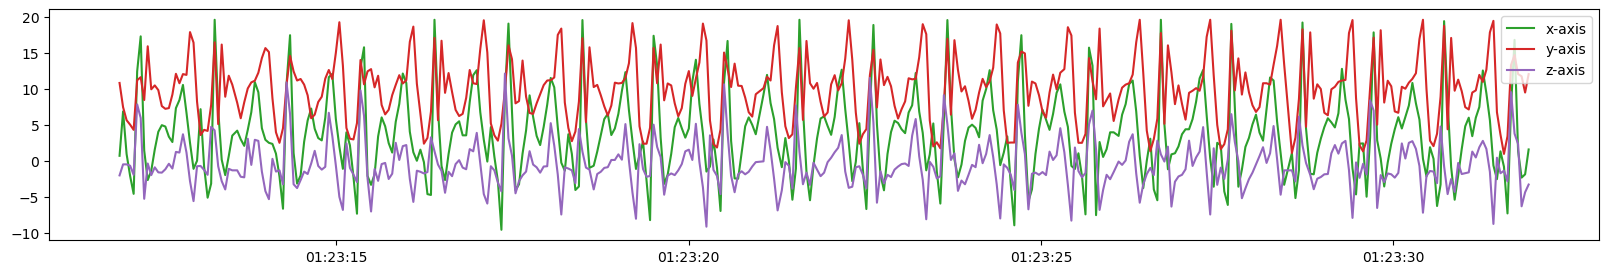

In [13]:
id = 1
segment = 1
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['x-acc'], label='x-axis', color='C2')
ax.plot(df_user['timestamp'], df_user['y-acc'], label='y-axis', color='C3')
ax.plot(df_user['timestamp'], df_user['z-acc'], label='z-axis', color='C4')
ax.legend(loc = 'upper right')

#### Check id=1's jogging data

activity type: Jogging


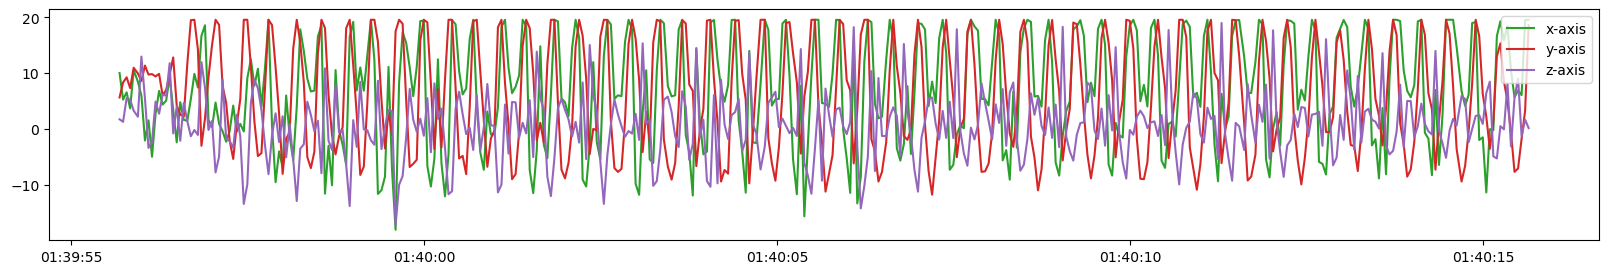

In [14]:
id = 1
segment = 5
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['x-acc'], label='x-axis', color='C2')
ax.plot(df_user['timestamp'], df_user['y-acc'], label='y-axis', color='C3')
ax.plot(df_user['timestamp'], df_user['z-acc'], label='z-axis', color='C4')
ax.legend(loc = 'upper right')

#### Check id=1's upstairs data

activity type: Upstairs


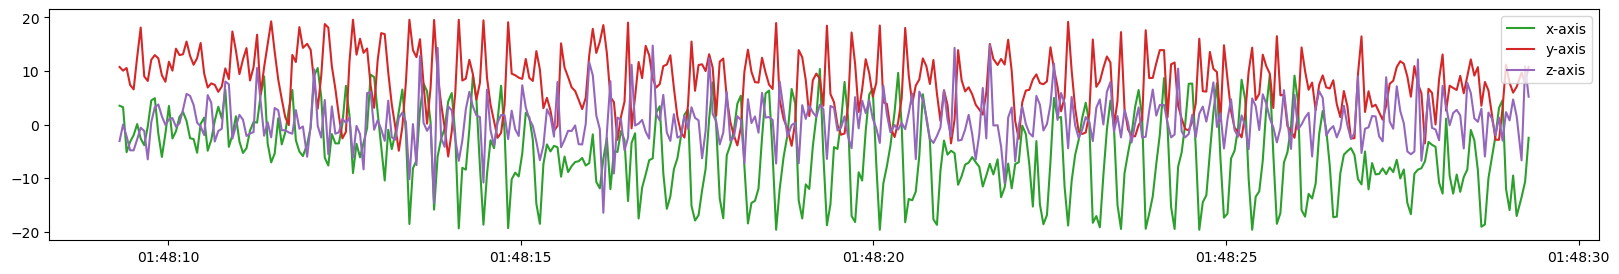

In [15]:
id = 1
segment = 6
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['x-acc'], label='x-axis', color='C2')
ax.plot(df_user['timestamp'], df_user['y-acc'], label='y-axis', color='C3')
ax.plot(df_user['timestamp'], df_user['z-acc'], label='z-axis', color='C4')
ax.legend(loc = 'upper right')

#### Check id=36's downstairs data

activity type: Downstairs


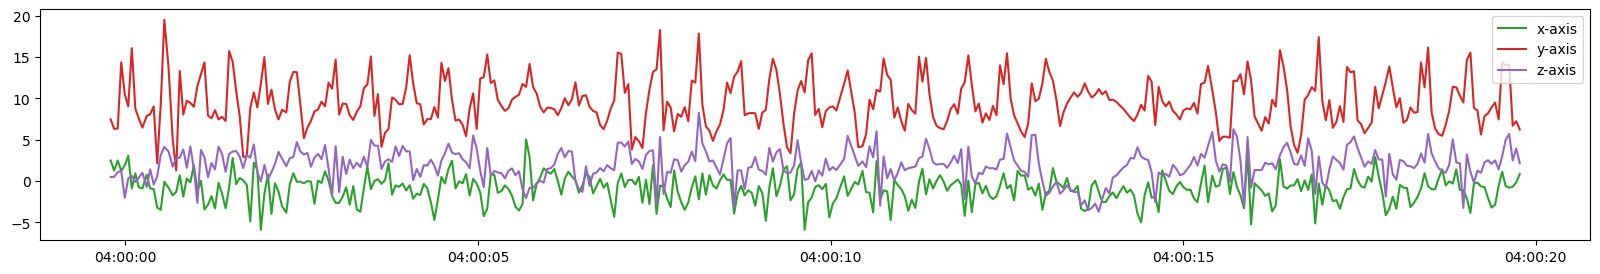

In [16]:
id = 36
segment = 7
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['x-acc'], label='x-axis', color='C2')
ax.plot(df_user['timestamp'], df_user['y-acc'], label='y-axis', color='C3')
ax.plot(df_user['timestamp'], df_user['z-acc'], label='z-axis', color='C4')
ax.legend(loc = 'upper right')

### Check id=36's sitting data

activity type: Sitting


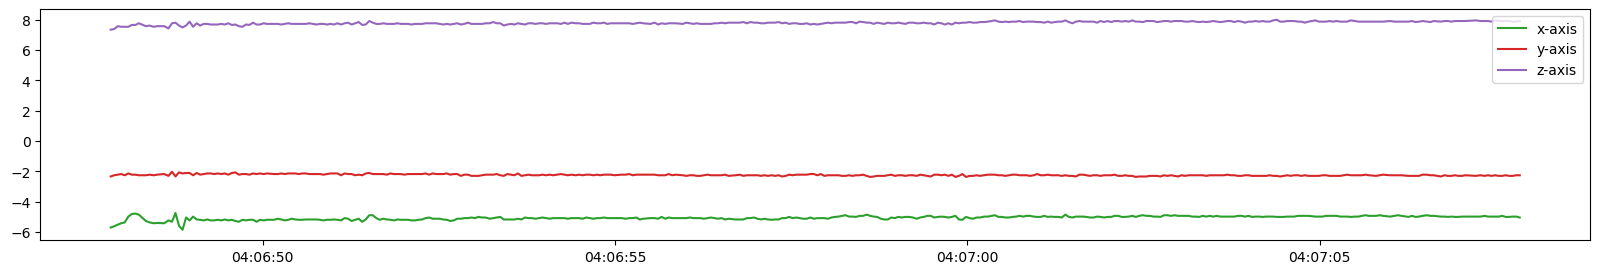

In [17]:
id = 36
segment = 12
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['x-acc'], label='x-axis', color='C2')
ax.plot(df_user['timestamp'], df_user['y-acc'], label='y-axis', color='C3')
ax.plot(df_user['timestamp'], df_user['z-acc'], label='z-axis', color='C4')
ax.legend(loc = 'upper right')

### Check id=36's standing data

activity type: Standing


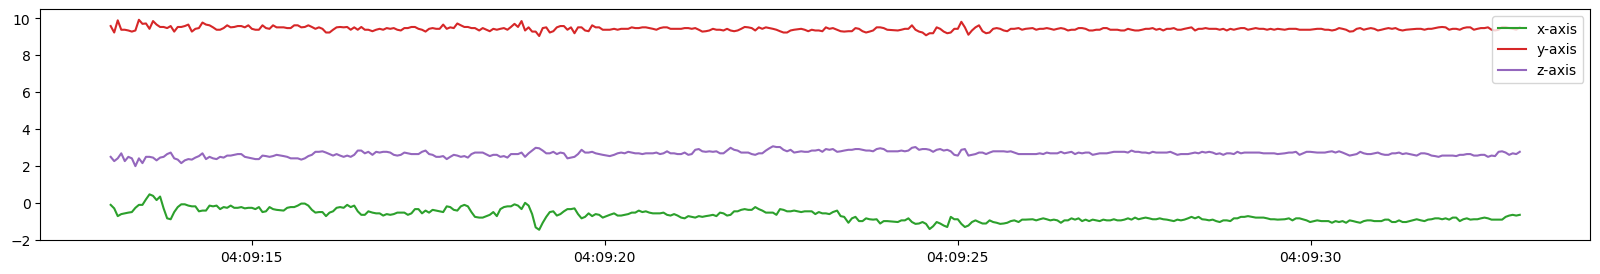

In [18]:
id = 36
segment = 13
df_user = data_df_sorted.loc[(data_df_sorted['user'] == id) & (data_df_sorted['segment'] == segment)]
activity = df_user['activity'].iloc[0]
print(f'activity type: {activity}')
fig, ax = plt.subplots(figsize=(20, 3))
first_timestamp = df_user['timestamp'].iloc[0]
end_timestamp = first_timestamp + np.timedelta64(20, 's')
df_user = df_user[(df_user['timestamp'] >= first_timestamp) & (df_user['timestamp'] <= end_timestamp)]
ax.plot(df_user['timestamp'], df_user['x-acc'], label='x-axis', color='C2')
ax.plot(df_user['timestamp'], df_user['y-acc'], label='y-axis', color='C3')
ax.plot(df_user['timestamp'], df_user['z-acc'], label='z-axis', color='C4')
ax.legend(loc = 'upper right')

Because the data looks clean enough overall and smoothing too much may make differnt activity signals look similar, I did not apply any smoothing methods.

Also, although I calculated magnitude, keeping x/y/z axes information seems to be important, especially when distinguishing between standing and sitting. Instead of only using magnitude, I decided to calculate time and frequency domain features for all axes separately.

By visual inspection, most of the recurring patterns can be captured by 5-sec windows. Although the authors adopted 10-sec windows, I decided to adopt 5-sec windows in the feature extraction process.

## **Applying windows and extracting features**

Then, apply moving windows and extract features for each window/axis using 5-sec moving windows.

Although overlapping windows can increase the number of instances and also can capture edges of the windows, I decided to use non-overlapping windows to avoid potential data leakage. We used regular 10-fold cross validation as a part of evaluation, but this method does not account for which instance belongs to which user. Therefore, if I apply overlapping windows, instances calculated using the same data might go into train and test data, which could potentially improve the classification performance significantly. To avoid this problem, I did not use overlapping windows and set the `step_size` parameter as the same as the window size.

**Features calculated**
- time-domain features calculated with `extract_features.py` for x/y/z-axes
- frequency-domain features calculated with `extract_features.py` for x/y/z-axes
- average magnitude in the window (the same feature used in the original paper)

In [19]:
window_sec = 5
window_size = fs * window_sec
step_size = window_size

all_features = []
cols_acc = ['x-acc', 'y-acc', 'z-acc']

# For each user and segment
for (user, segment), group in data_df_sorted.groupby(['user', 'segment']):
    group = group.reset_index(drop=True)
    # Sliding window
    for start in range(0, len(group) - window_size, step_size):
        activity = group.loc[start, 'activity']
        window = group.loc[start:start + window_size - 1, cols_acc]
        if len(window) == window_size:
            time_features_window = []
            freq_features_window = []
            for col in cols_acc:
                time_features_col = ef.get_time_series_features(window[col])
                freq_features_col = ef.get_freq_domain_features(window[col])
                time_features_window.append(time_features_col)
                freq_features_window.append(freq_features_col)
            all_features.append([user, segment, activity, np.mean(group.loc[start:start + window_size - 1, 'magnitude']), time_features_window, freq_features_window])

# Convert to DataFrame
features_df = pd.DataFrame({
    'user': [f[0] for f in all_features],
    'segment': [f[1] for f in all_features],
    'activity': [f[2] for f in all_features],
    'magnitude_mean':[f[3] for f in all_features]
})

time_feature_names = ["mean", "std", "aad", "min", "max", "maxmin_diff", "median", "mad", "IQR", "neg_count", "pos_count", "above_mean", "num_peaks", "skew", "kurtosis", "energy", "sma"]
for i, col in enumerate(cols_acc):
    for j, feat in enumerate(time_feature_names):
        features_df[f'{col}_{feat}'] = [f[4][i][j] for f in all_features]

freq_feature_names = ["dc", "mean", "std", "aad", "min", "max", "maxmin_diff", "median", "mad", "IQR", "neg_count", "pos_count", "above_mean", "num_peaks", "skew", "kurtosis", "energy", "sma"]
for i, col in enumerate(cols_acc):
    for j, feat in enumerate(freq_feature_names):
        features_df[f'freq_{col}_{feat}'] = [f[5][i][j] for f in all_features]

features_df

,user,segment,activity,magnitude_mean,x-acc_mean,x-acc_std,x-acc_aad,x-acc_min,x-acc_max,x-acc_maxmin_diff,...,freq_z-acc_mad,freq_z-acc_IQR,freq_z-acc_neg_count,freq_z-acc_pos_count,freq_z-acc_above_mean,freq_z-acc_num_peaks,freq_z-acc_skew,freq_z-acc_kurtosis,freq_z-acc_energy,freq_z-acc_sma
0,1,1,Walking,11.927003,3.6538,5.508084,4.200456,-7.35,19.57,26.92,...,7.543528,17.985897,0,50,16,15,1.942716,3.525171,1027.602156,24.290444
1,1,1,Walking,12.494901,3.8955,5.942122,4.611740,-9.58,19.57,29.15,...,12.181348,23.873705,0,50,19,15,1.238485,1.710798,1163.838904,28.063572
2,1,1,Walking,12.393202,3.8653,5.843144,4.424276,-8.96,19.57,28.53,...,10.326222,20.111355,0,50,20,14,2.484931,8.054639,1197.731656,26.557628
3,1,1,Walking,12.223644,3.5060,5.711999,4.428160,-7.31,19.38,26.69,...,6.287766,15.720837,0,50,14,15,3.126015,11.245573,1082.673916,23.691180
4,1,1,Walking,12.442034,3.3339,5.719622,4.290778,-8.54,19.57,28.11,...,8.283354,15.756354,0,50,15,15,2.284070,6.129138,1173.189572,25.850793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10503,36,13,Standing,9.853696,-1.2682,0.234868,0.191308,-1.80,-0.53,1.27,...,0.492956,1.192481,0,50,20,17,1.803791,3.944588,2.865158,1.322103
10504,36,13,Standing,9.850462,-1.3256,0.166531,0.117480,-1.80,-0.84,0.96,...,0.329829,0.691853,0,50,19,17,2.160241,6.398853,1.062943,0.789148
10505,36,13,Standing,9.841763,-1.2971,0.101087,0.083680,-1.50,-1.08,0.42,...,0.108188,0.209342,0,50,18,14,1.581838,2.559188,0.305556,0.466370
10506,36,13,Standing,9.843887,-1.3409,0.112668,0.087588,-1.69,-1.04,0.65,...,0.206364,0.470274,0,50,17,15,3.459112,12.662319,0.837105,0.624537


Because SVM assumes that all features are centered around zero, it performs poorly when data are not normalized. Here, I performed data standardization by removing the mean and scaling to unit variance.

In [20]:
scaler = StandardScaler()
# Normalize feature data
features_df_normalized = features_df.copy()
for col in features_df_normalized.columns:
    if (col != 'user') &  (col != 'segment') &  (col != 'activity'):
        features_df_normalized[col] = scaler.fit_transform(features_df_normalized[[col]])
features_df_normalized

,user,segment,activity,magnitude_mean,x-acc_mean,x-acc_std,x-acc_aad,x-acc_min,x-acc_max,x-acc_maxmin_diff,...,freq_z-acc_mad,freq_z-acc_IQR,freq_z-acc_neg_count,freq_z-acc_pos_count,freq_z-acc_above_mean,freq_z-acc_num_peaks,freq_z-acc_skew,freq_z-acc_kurtosis,freq_z-acc_energy,freq_z-acc_sma
0,1,1,Walking,0.003642,0.658907,0.365928,0.209828,0.190888,1.339643,0.802898,...,-0.521124,-0.344611,0.0,0.0,-0.844862,0.021696,0.126263,-0.238239,-0.480674,-0.362504
1,1,1,Walking,0.304121,0.712595,0.524153,0.382165,-0.149823,1.339643,1.035853,...,0.272748,0.135058,0.0,0.0,0.102138,0.021696,-0.662203,-0.604228,-0.396438,-0.114420
2,1,1,Walking,0.250311,0.705887,0.488071,0.303613,-0.055096,1.339643,0.971085,...,-0.044800,-0.171454,0.0,0.0,0.417805,-0.527660,0.733335,0.675430,-0.375482,-0.213436
3,1,1,Walking,0.160597,0.626077,0.440264,0.305241,0.197000,1.311157,0.778871,...,-0.736077,-0.529141,0.0,0.0,-1.476195,0.021696,1.451102,1.319094,-0.446623,-0.401905
4,1,1,Walking,0.276148,0.587849,0.443043,0.247675,0.009074,1.339643,0.927210,...,-0.394485,-0.526247,0.0,0.0,-1.160529,0.021696,0.508449,0.287024,-0.390657,-0.259910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10503,36,13,Standing,-1.093358,-0.434400,-1.556375,-1.470092,1.038846,-1.673904,-1.876607,...,-1.727996,-1.712739,0.0,0.0,0.417805,1.120409,-0.029278,-0.153636,-1.114273,-1.872675
10504,36,13,Standing,-1.095069,-0.447150,-1.581287,-1.501027,1.038846,-1.720381,-1.908991,...,-1.755919,-1.753524,0.0,0.0,0.102138,1.120409,0.369808,0.341430,-1.115387,-1.907717
10505,36,13,Standing,-1.099672,-0.440820,-1.605144,-1.515190,1.084681,-1.756364,-1.965401,...,-1.793858,-1.792833,0.0,0.0,-0.213529,-0.527660,-0.277781,-0.433094,-1.115855,-1.928939
10506,36,13,Standing,-1.098548,-0.450549,-1.600922,-1.513553,1.055652,-1.750367,-1.941375,...,-1.777053,-1.771576,0.0,0.0,-0.529195,0.021696,1.824042,1.604876,-1.115527,-1.918540


In [21]:
pd.set_option('display.max_columns', None)
features_df_normalized.describe()

,user,segment,magnitude_mean,x-acc_mean,x-acc_std,x-acc_aad,x-acc_min,x-acc_max,x-acc_maxmin_diff,x-acc_median,x-acc_mad,x-acc_IQR,x-acc_neg_count,x-acc_pos_count,x-acc_above_mean,x-acc_num_peaks,x-acc_skew,x-acc_kurtosis,x-acc_energy,x-acc_sma,y-acc_mean,y-acc_std,y-acc_aad,y-acc_min,y-acc_max,y-acc_maxmin_diff,y-acc_median,y-acc_mad,y-acc_IQR,y-acc_neg_count,y-acc_pos_count,y-acc_above_mean,y-acc_num_peaks,y-acc_skew,y-acc_kurtosis,y-acc_energy,y-acc_sma,z-acc_mean,z-acc_std,z-acc_aad,z-acc_min,z-acc_max,z-acc_maxmin_diff,z-acc_median,z-acc_mad,z-acc_IQR,z-acc_neg_count,z-acc_pos_count,z-acc_above_mean,z-acc_num_peaks,z-acc_skew,z-acc_kurtosis,z-acc_energy,z-acc_sma,freq_x-acc_dc,freq_x-acc_mean,freq_x-acc_std,freq_x-acc_aad,freq_x-acc_min,freq_x-acc_max,freq_x-acc_maxmin_diff,freq_x-acc_median,freq_x-acc_mad,freq_x-acc_IQR,freq_x-acc_neg_count,freq_x-acc_pos_count,freq_x-acc_above_mean,freq_x-acc_num_peaks,freq_x-acc_skew,freq_x-acc_kurtosis,freq_x-acc_energy,freq_x-acc_sma,freq_y-acc_dc,freq_y-acc_mean,freq_y-acc_std,freq_y-acc_aad,freq_y-acc_min,freq_y-acc_max,freq_y-acc_maxmin_diff,freq_y-acc_median,freq_y-acc_mad,freq_y-acc_IQR,freq_y-acc_neg_count,freq_y-acc_pos_count,freq_y-acc_above_mean,freq_y-acc_num_peaks,freq_y-acc_skew,freq_y-acc_kurtosis,freq_y-acc_energy,freq_y-acc_sma,freq_z-acc_dc,freq_z-acc_mean,freq_z-acc_std,freq_z-acc_aad,freq_z-acc_min,freq_z-acc_max,freq_z-acc_maxmin_diff,freq_z-acc_median,freq_z-acc_mad,freq_z-acc_IQR,freq_z-acc_neg_count,freq_z-acc_pos_count,freq_z-acc_above_mean,freq_z-acc_num_peaks,freq_z-acc_skew,freq_z-acc_kurtosis,freq_z-acc_energy,freq_z-acc_sma
count,10508.000000,10508.000000,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,10508.0,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,10508.0,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,10508.0,10508.0,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04,1.050800e+04
mean,18.810335,4.894747,3.942834e-16,-1.166167e-16,2.188327e-16,1.338438e-16,-5.611761e-16,1.434795e-16,-2.424360e-16,-1.127867e-16,-2.019068e-16,1.394646e-16,-9.928614e-16,-5.050733e-16,6.705291e-16,-2.509000e-15,1.294485e-16,-3.186556e-17,1.295119e-16,-5.398444e-17,2.229427e-16,1.108533e-16,-4.727429e-16,1.267649e-16,3.520214e-16,-4.551196e-16,-3.297493e-16,-1.460786e-16,-2.264187e-16,1.865445e-16,-8.978987e-16,1.267807e-16,-1.765284e-16,-4.603918e-18,2.504024e-18,3.202774e-16,1.702208e-16,1.291104e-16,-5.265847e-17,5.145189e-16,2.597423e-16,2.125779e-17,-5.940771e-16,8.657373e-17,1.230881e-16,-1.073878e-16,-2.954960e-16,-1.428202e-15,-1.816210e-17,-1.046658e-15,1.402042e-16,1.740138e-17,-1.431309e-16,1.270713e-16,-9.595590e-17,5.115182e-16,5.887098e-17,-2.949254e-16,8.967999e-17,-7.805793e-17,-8.110080e-17,-1.094163e-16,-4.211409e-17,2.689977e-17,0.0,-2.434303e-13,-9.371654e-16,1.198582e-15,3.425653e-16,-5.572352e-16,7.596596e-18,5.115182e-16,-4.510730e-16,2.981162e-16,1

Because some features are all zero, remove those features.

In [22]:
# Drop unuseful features
features_df_normalized.drop(columns=['freq_x-acc_neg_count', 'freq_y-acc_neg_count', 'freq_z-acc_neg_count', 'freq_z-acc_pos_count'], inplace=True)

## **Train model and evaluate the performance**

Here, I used Support Vector Machine as a machine learning model.

In [23]:
# Extract features and labels
y = features_df_normalized['activity'].values
X = features_df_normalized.drop(columns=['activity', 'segment', 'user'], inplace=False)

### 10-fold CV

In [24]:
# Train SVM classifier and get predictions
clf = svm.SVC()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=30)
y_pred_cv = cross_val_predict(clf, X, y, cv=cv)

In [25]:
# Get classification results
report_cv  = classification_report(y, y_pred_cv, output_dict=True)
accuracy_cv = report_cv['accuracy']
report_df_cv = pd.DataFrame(report_cv).drop(columns=['accuracy']).transpose()
print("Accuracy:", accuracy_cv)
print(tabulate(report_df_cv, headers='keys', tablefmt='pretty', floatfmt=".2f"))

Accuracy: 0.9528930338789494
+--------------+--------------------+--------------------+--------------------+---------+
|              |     precision      |       recall       |      f1-score      | support |
+--------------+--------------------+--------------------+--------------------+---------+
|  Downstairs  | 0.8590455049944506 | 0.8199152542372882 | 0.8390243902439024 |  944.0  |
|   Jogging    | 0.9905985584456283 |  0.98504206918043  |     0.9878125      | 3209.0  |
|   Sitting    | 0.9860383944153578 | 0.9658119658119658 | 0.9758203799654578 |  585.0  |
|   Standing   | 0.9609053497942387 | 0.989406779661017  | 0.9749478079331941 |  472.0  |
|   Upstairs   | 0.8659517426273459 | 0.8353448275862069 | 0.8503729706011409 | 1160.0  |
|   Walking    | 0.9620103822557811 | 0.985258579023683  | 0.9734957020057307 | 4138.0  |
|  macro avg   | 0.9374249887554672 | 0.9301299125834319 | 0.9335789584582376 | 10508.0 |
| weighted avg | 0.9521747715859146 | 0.9528930338789494 | 0.9523903202

Text(0.5, 1.0, 'Confusion Matrix (10-Fold CV)')

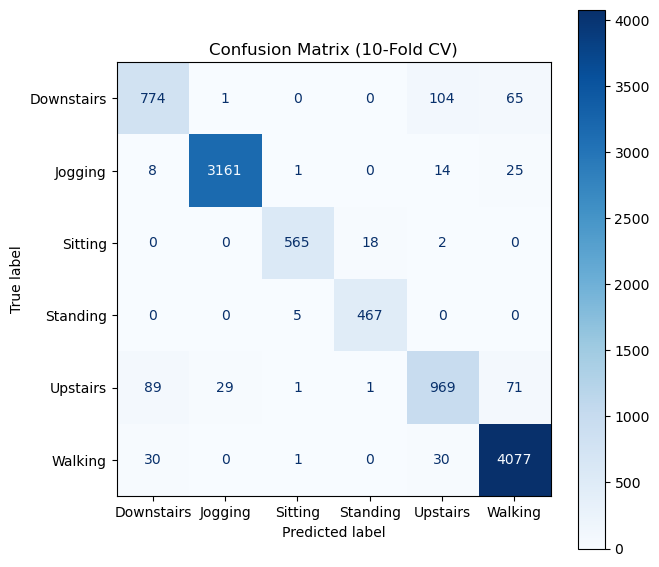

In [26]:
# Get confusion matrix
labels = np.unique(y)
cm_cv = confusion_matrix(y, y_pred_cv)
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_predictions(y, y_pred_cv, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix (10-Fold CV)')

### Leave-one-group-out CV

Here, I used leave-one-group-out CV with 10 splits to evaluate the performance.

In [27]:
clf = svm.SVC()

# List up all users
users = features_df_normalized['user']

# GroupKFold
groupkfold = GroupKFold(n_splits=10)

# Train SVM classifier and get predictions
y_pred_leave_group_out = cross_val_predict(clf, X, y, cv=groupkfold, groups=users)

In [28]:
# Get classification results
report_leave_group_out  = classification_report(y, y_pred_leave_group_out, output_dict=True)
accuracy_leave_group_out = report_leave_group_out['accuracy']
report_df_leave_group_out = pd.DataFrame(report_leave_group_out).drop(columns=['accuracy']).transpose()
print("Accuracy:", accuracy_leave_group_out)
print(tabulate(report_df_leave_group_out, headers='keys', tablefmt='pretty', floatfmt=".2f"))

Accuracy: 0.8801865245527217
+--------------+--------------------+--------------------+--------------------+---------+
|              |     precision      |       recall       |      f1-score      | support |
+--------------+--------------------+--------------------+--------------------+---------+
|  Downstairs  |  0.73224043715847  | 0.7097457627118644 | 0.720817643894567  |  944.0  |
|   Jogging    | 0.9157270029673591 | 0.961670302274852  | 0.9381364949080407 | 3209.0  |
|   Sitting    | 0.9663716814159292 | 0.9333333333333333 | 0.9495652173913044 |  585.0  |
|   Standing   | 0.9213709677419355 | 0.9682203389830508 | 0.9442148760330578 |  472.0  |
|   Upstairs   | 0.6585976627712855 | 0.6801724137931034 | 0.6692111959287532 | 1160.0  |
|   Walking    | 0.9336528758829465 | 0.8943934267762204 | 0.9136015798568256 | 4138.0  |
|  macro avg   | 0.8546601046563209 | 0.8579225963120708 | 0.8559245013354247 | 10508.0 |
| weighted avg | 0.8809903259250748 | 0.8801865245527217 | 0.8801737025

Text(0.5, 1.0, 'Confusion Matrix (Leave-one-group-out CV)')

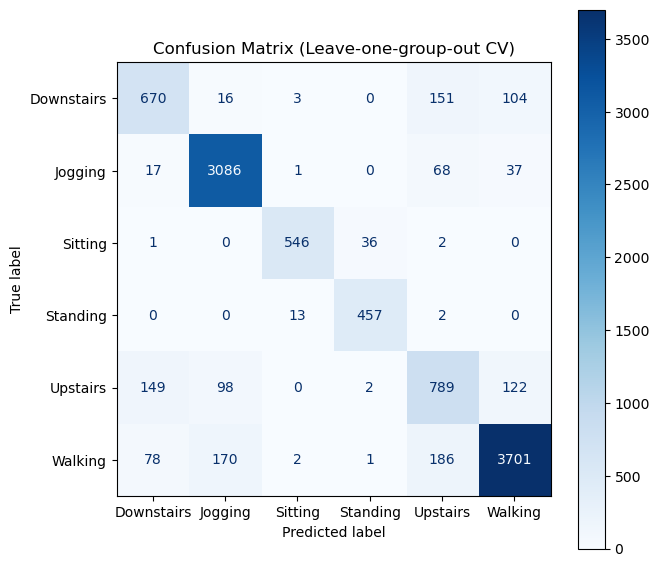

In [29]:
# Get confusion matrix
cm_leave_group_out = confusion_matrix(y, y_pred_leave_group_out)
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_predictions(y, y_pred_leave_group_out, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix (Leave-one-group-out CV)')

### Train/test split

Here, I used the first 29 users as train sets and the last 7 users as test sets.

In [30]:
clf = svm.SVC()

# Split users into train and test sets
train_id = users.unique()[0:29]
test_id = users.unique()[29:]
print(f'train ids: {train_id}')
print(f'test ids: {test_id}')

train ids: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
test ids: [30 31 32 33 34 35 36]


In [31]:
# Split into training and test sets
X_train = features_df_normalized.loc[features_df_normalized['user'].isin(train_id)].drop(columns=['activity', 'segment', 'user'], inplace=False)
y_train = features_df_normalized.loc[features_df_normalized['user'].isin(train_id)]['activity'].values
X_test = features_df_normalized.loc[features_df_normalized['user'].isin(test_id)].drop(columns=['activity', 'segment', 'user'], inplace=False)
y_test = features_df_normalized.loc[features_df_normalized['user'].isin(test_id)]['activity'].values

In [32]:
# Train and predict
clf.fit(X_train, y_train)
y_pred_split = clf.predict(X_test)

In [33]:
# Get classification results
report_split  = classification_report(y_test, y_pred_split, output_dict=True)
accuracy_split = report_split['accuracy']
report_df_split = pd.DataFrame(report_split).drop(columns=['accuracy']).transpose()
print("Accuracy:", accuracy_split)
print(tabulate(report_df_split, headers='keys', tablefmt='pretty', floatfmt=".2f"))

Accuracy: 0.8617848970251716
+--------------+--------------------+--------------------+--------------------+---------+
|              |     precision      |       recall       |      f1-score      | support |
+--------------+--------------------+--------------------+--------------------+---------+
|  Downstairs  | 0.8855421686746988 | 0.7135922330097088 | 0.7903225806451614 |  206.0  |
|   Jogging    | 0.7965425531914894 | 0.9388714733542319 | 0.8618705035971224 |  638.0  |
|   Sitting    |        0.94        | 0.9276315789473685 | 0.9337748344370861 |  152.0  |
|   Standing   | 0.9153846153846154 | 0.9153846153846154 | 0.9153846153846154 |  130.0  |
|   Upstairs   | 0.7611336032388664 | 0.8068669527896996 | 0.7833333333333333 |  233.0  |
|   Walking    | 0.9310810810810811 | 0.8341404358353511 | 0.8799489144316731 |  826.0  |
|  macro avg   | 0.8716140035951252 | 0.8560812148868293 | 0.8607724636381654 | 2185.0  |
| weighted avg | 0.8690677062749597 | 0.8617848970251716 | 0.8617702872

Text(0.5, 1.0, 'Confusion Matrix (Train-Test Split)')

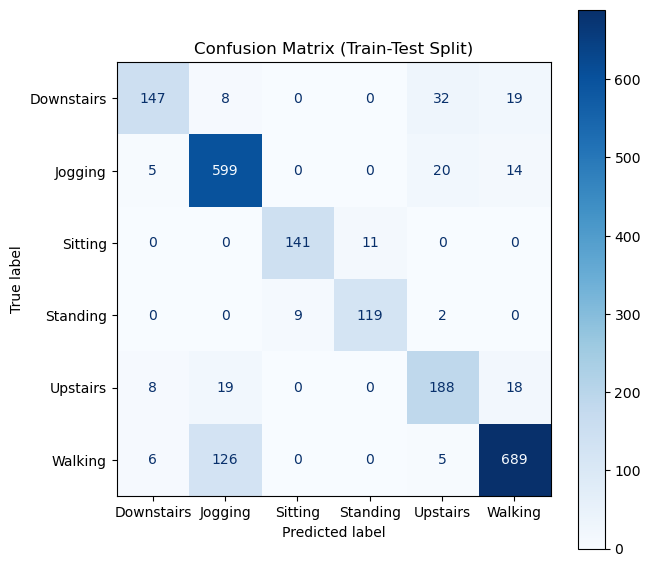

In [34]:
# Get confusion matrix
cm_split = confusion_matrix(y_test, y_pred_split)
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_split, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix (Train-Test Split)')

## **Summary**

Overall, the model performed better than the reference performance provided in the assignment instructions. It especially performed better in detecting sitting vs standing, potentially because x/y/z-axes information was maintained rather than aggregated. 

The choice of evaluation method did affect the outcome. Leave-one-group-out CV and train-test split resulted in lower performance overall than that of 10-fold cross validation, more accurately capturing the model performance on unknown users' data. 

Although the model performed well in general even without hyperparameter tuning, classification of upstairs, downstairs, and walking seemed to be a relatively difficult task compared to other activities.